In [33]:
import warnings
from matplotlib.ticker import MultipleLocator
import string
from prettytable import PrettyTable
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
import re
import os
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import ast

In [34]:
df = pd.read_csv("../input/multilabelsongs/MultiLabelSongs_RO_prepared_preprocessed.csv")
df.head(2)

,artist,genre,title,album,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,vrea deranja vrea promi vrea vrea deranja vrea...,"['Calmness', 'Sadness']"
1,Damian Marley,Reggae,Here We Go,Stony Hill,merge ego mare gon na problemă juca erou putea...,"['Power', 'Tension']"


In [35]:
df['labels'] = df['labels'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
df['labels'] = df['labels'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
df.head(2)

,artist,genre,title,album,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,vrea deranja vrea promi vrea vrea deranja vrea...,"Calmness, Sadness"
1,Damian Marley,Reggae,Here We Go,Stony Hill,merge ego mare gon na problemă juca erou putea...,"Power, Tension"


In [36]:
df['labels'] = df['labels'].str.split(',\s*')
df.head(2)

,artist,genre,title,album,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,vrea deranja vrea promi vrea vrea deranja vrea...,"[Calmness, Sadness]"
1,Damian Marley,Reggae,Here We Go,Stony Hill,merge ego mare gon na problemă juca erou putea...,"[Power, Tension]"


In [37]:
all_emotions = sorted(list(set([e for labels in df['labels'] for e in labels])))
mlb = MultiLabelBinarizer(classes=all_emotions)
labels_bin = mlb.fit_transform(df['labels'])

for i, label in enumerate(mlb.classes_):
    print(f"{i}: {label}")

0: Amazement
1: Calmness
2: Joyful activation
3: Nostalgia
4: Power
5: Sadness
6: Solemnity
7: Tenderness
8: Tension


In [38]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['lyrics'].tolist(), labels_bin, test_size=0.2, random_state=42
)

In [39]:
def evaluate(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=all_emotions, zero_division=0)
    return f1_micro, f1_macro, precision, recall, acc, report, all_labels, all_preds

In [40]:
def plot_confusion_per_class(true_labels, pred_labels, class_names, epoch=None):
    for i, class_name in enumerate(class_names):
        cm = confusion_matrix(true_labels[:, i], pred_labels[:, i])
        plt.figure(figsize=(3.5, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Not ' + class_name, class_name],
                    yticklabels=['Not ' + class_name, class_name])
        plt.xlabel("Predicted")
        plt.ylabel("True")
        title = f"Confusion Matrix: {class_name}"
        if epoch is not None:
            title += f" (Epoch {epoch+1})"
        plt.title(title)
        plt.tight_layout()
        plt.show()

In [41]:
class LyricsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]
        encoding = self.tokenizer(text,
                                  max_length=self.max_len,
                                  padding='max_length',
                                  truncation=True,
                                  return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.FloatTensor(labels)
        }

class MultiLabelClassificationModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # [CLS] token
        dropped = self.dropout(pooled_output)
        logits = self.classifier(dropped)
        return logits 

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = "xlm-roberta-base"
#model_name = "readerbench/RoBERT-base"
#model_name = "racai/distilbert-base-romanian-cased"
#model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = MultiLabelClassificationModel(model_name, num_labels=len(all_emotions))
model.to(device)

train_dataset = LyricsDataset(train_texts, train_labels, tokenizer)
val_dataset = LyricsDataset(val_texts, val_labels, tokenizer)
train_dataset = LyricsDataset(train_texts, train_labels, tokenizer)
val_dataset = LyricsDataset(val_texts, val_labels, tokenizer)

idx = 0
sample = train_dataset[idx]
original_text = train_texts[idx]
print("=== Text original ===")
print(original_text)
print("\n=== Token IDs ===")
print(sample['input_ids'])
print("\n=== Attention Mask ===")
print(sample['attention_mask'])
print("\n=== Tokens ===")
print(tokenizer.convert_ids_to_tokens(sample['input_ids']))
print("\n=== Label ===")
print(sample['labels'])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

=== Text original ===
imagină melodie dragoste melodie dragoste incredibil putea vedea veni ochi prime melodie putea ochi piesa striga tip bun nigga escrocher bloc trebui uita trebui uita bloc trebui uita bloc vreme rău acum clasă schimbă prognoză punct vedere lovitură trece verifica mic mall jos schimbi putea vrea seamă putea putea putea crește interior nigga bolnav putea vedea ochi ajunge melodie putea vedea veni ochi ajunge las melodie putea ochi ajunge melodie strigă putea vedea ochi ajunge melodie repetă pretinde comunitateaduropean urmă bitch crea let see clip shopping sprees pull visa quick nigga bad credit helped lea whip helped get keys dot happy poor got rich signals got crossed got Flipped rather know made leav shit mad speed quick let see cheese helped Bitches get amnesie quick used cut amic acum spune iubi atinge prezenta aminti aminti putea veni ochi ajunge melodie putea ochi melodie putea ochi ochi melodie putea ochi ochi melodie putea ochi ochi melodie trebui piesă prie

In [43]:
for param in model.model.embeddings.parameters():
    param.requires_grad = True

# Freeze primele 2 layere in encoder
#for name, param in model.model.encoder.named_parameters():
#    if "layer." in name:
#        layer_num = int(name.split('.')[1])
#        if layer_num < 2:
#            param.requires_grad = False

# Calculez pos_weight pe baza distribuției claselor în train_labels
if not isinstance(train_labels, torch.Tensor):
    train_labels_tensor = torch.tensor(train_labels)
else:
    train_labels_tensor = train_labels

pos_counts = train_labels_tensor.sum(dim=0)
neg_counts = train_labels_tensor.shape[0] - pos_counts
pos_weight = neg_counts / pos_counts
print("Pos weight per class:", pos_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
#criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-2)

Pos weight per class: tensor([4.1034, 3.8000, 2.4154, 1.6350, 1.5517, 0.9603, 2.1601, 1.3617, 1.0993])


In [44]:
train_losses = []
train_f1micros, train_f1macros, val_f1micros, val_f1macros = [], [], [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_accs, val_accs = [], []

best_model_path = "checkpoint.pt"
best_score = 0
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        if epoch == 0 and loop.n == 0:
            print("input_ids shape:", input_ids.shape)
            print("attention_mask shape:", attention_mask.shape)
            print("labels shape:", labels.shape)
            print("labels example:", labels[0])

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_f1_micro, train_f1_macro, train_prec, train_rec, train_acc, _, _, _ = evaluate(model, train_loader)
    train_f1micros.append(train_f1_micro)
    train_f1macros.append(train_f1_macro)
    train_precisions.append(train_prec)
    train_recalls.append(train_rec)
    train_accs.append(train_acc)

    val_f1_micro, val_f1_macro, val_prec, val_rec, val_acc, _, _, _ = evaluate(model, val_loader)
    val_f1micros.append(val_f1_micro)
    val_f1macros.append(val_f1_macro)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)
    val_accs.append(val_acc)

    val_score = val_f1_micro + val_f1_macro
    if val_score > best_score:
        best_score = val_score
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_score': best_score
        }
        torch.save(checkpoint, best_model_path)
        print("Checkpoint salvat cu succes.")
        print(f"Model salvat: Epoca {epoch+1} cu scor val total: {val_score:.4f}")

    print(f"\nEpoch {epoch+1}")
    print(f"Train -> F1 macro: {train_f1_macro:.4f}, F1 micro: {train_f1_micro:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, Acc: {train_acc:.4f}, Loss: {avg_train_loss:.4f}")
    print(f" Val  -> F1 macro: {val_f1_macro:.4f}, F1 micro: {val_f1_micro:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, Acc: {val_acc:.4f}")

Epoch 1:   0%|          | 0/56 [00:00<?, ?it/s]

input_ids shape: torch.Size([16, 512])
attention_mask shape: torch.Size([16, 512])
labels shape: torch.Size([16, 9])
labels example: tensor([0., 0., 0., 1., 0., 1., 0., 0., 1.], device='cuda:0')


Epoch 1: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.964]


Checkpoint salvat cu succes.
Model salvat: Epoca 1 cu scor val total: 0.8243

Epoch 1
Train -> F1 macro: 0.3512, F1 micro: 0.4441, Precision: 0.3128, Recall: 0.6143, Acc: 0.0011, Loss: 0.9225
 Val  -> F1 macro: 0.3621, F1 micro: 0.4622, Precision: 0.3165, Recall: 0.6088, Acc: 0.0045


Epoch 2: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.781]


Checkpoint salvat cu succes.
Model salvat: Epoca 2 cu scor val total: 0.9793

Epoch 2
Train -> F1 macro: 0.4963, F1 micro: 0.5217, Precision: 0.4590, Recall: 0.5919, Acc: 0.0056, Loss: 0.9092
 Val  -> F1 macro: 0.4700, F1 micro: 0.5093, Precision: 0.4521, Recall: 0.5389, Acc: 0.0090


Epoch 3: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.948]


Checkpoint salvat cu succes.
Model salvat: Epoca 3 cu scor val total: 1.0014

Epoch 3
Train -> F1 macro: 0.5197, F1 micro: 0.5378, Precision: 0.4849, Recall: 0.5912, Acc: 0.0270, Loss: 0.8843
 Val  -> F1 macro: 0.4881, F1 micro: 0.5133, Precision: 0.4677, Recall: 0.5338, Acc: 0.0270


Epoch 4: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.905]


Checkpoint salvat cu succes.
Model salvat: Epoca 4 cu scor val total: 1.0419

Epoch 4
Train -> F1 macro: 0.5475, F1 micro: 0.5579, Precision: 0.4865, Recall: 0.6991, Acc: 0.0214, Loss: 0.8629
 Val  -> F1 macro: 0.5163, F1 micro: 0.5256, Precision: 0.4776, Recall: 0.6292, Acc: 0.0135


Epoch 5: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.862]


Checkpoint salvat cu succes.
Model salvat: Epoca 5 cu scor val total: 1.0487

Epoch 5
Train -> F1 macro: 0.5879, F1 micro: 0.5896, Precision: 0.5429, Recall: 0.6890, Acc: 0.0315, Loss: 0.8471
 Val  -> F1 macro: 0.5166, F1 micro: 0.5320, Precision: 0.4905, Recall: 0.5824, Acc: 0.0270


Epoch 6: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.77] 



Epoch 6
Train -> F1 macro: 0.5788, F1 micro: 0.5949, Precision: 0.5727, Recall: 0.6494, Acc: 0.0597, Loss: 0.8082
 Val  -> F1 macro: 0.4674, F1 micro: 0.5064, Precision: 0.4864, Recall: 0.5105, Acc: 0.0315


Epoch 7: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.787]


Checkpoint salvat cu succes.
Model salvat: Epoca 7 cu scor val total: 1.1122

Epoch 7
Train -> F1 macro: 0.6597, F1 micro: 0.6639, Precision: 0.5882, Recall: 0.7797, Acc: 0.0439, Loss: 0.7842
 Val  -> F1 macro: 0.5394, F1 micro: 0.5728, Precision: 0.5005, Recall: 0.6175, Acc: 0.0180


Epoch 8: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.558]


Checkpoint salvat cu succes.
Model salvat: Epoca 8 cu scor val total: 1.1415

Epoch 8
Train -> F1 macro: 0.6835, F1 micro: 0.6937, Precision: 0.6311, Recall: 0.7632, Acc: 0.0946, Loss: 0.7347
 Val  -> F1 macro: 0.5574, F1 micro: 0.5841, Precision: 0.5467, Recall: 0.5807, Acc: 0.0495


Epoch 9: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.658]



Epoch 9
Train -> F1 macro: 0.6897, F1 micro: 0.7021, Precision: 0.6469, Recall: 0.7806, Acc: 0.1059, Loss: 0.6959
 Val  -> F1 macro: 0.5033, F1 micro: 0.5391, Precision: 0.5009, Recall: 0.5568, Acc: 0.0450


Epoch 10: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.72] 



Epoch 10
Train -> F1 macro: 0.7256, F1 micro: 0.7345, Precision: 0.6616, Recall: 0.8196, Acc: 0.1261, Loss: 0.6553
 Val  -> F1 macro: 0.5444, F1 micro: 0.5669, Precision: 0.5229, Recall: 0.5800, Acc: 0.0586


Epoch 11: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.605]



Epoch 11
Train -> F1 macro: 0.7566, F1 micro: 0.7633, Precision: 0.7016, Recall: 0.8299, Acc: 0.1791, Loss: 0.6186
 Val  -> F1 macro: 0.5330, F1 micro: 0.5625, Precision: 0.5202, Recall: 0.5482, Acc: 0.0450


Epoch 12: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.567]



Epoch 12
Train -> F1 macro: 0.7747, F1 micro: 0.7782, Precision: 0.7260, Recall: 0.8388, Acc: 0.2095, Loss: 0.5779
 Val  -> F1 macro: 0.5143, F1 micro: 0.5510, Precision: 0.5112, Recall: 0.5239, Acc: 0.0631


Epoch 13: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.652]



Epoch 13
Train -> F1 macro: 0.7711, F1 micro: 0.7744, Precision: 0.7190, Recall: 0.8538, Acc: 0.1791, Loss: 0.5582
 Val  -> F1 macro: 0.5135, F1 micro: 0.5427, Precision: 0.5037, Recall: 0.5407, Acc: 0.0405


Epoch 14: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.453]



Epoch 14
Train -> F1 macro: 0.8115, F1 micro: 0.8075, Precision: 0.7572, Recall: 0.8766, Acc: 0.2275, Loss: 0.5212
 Val  -> F1 macro: 0.5189, F1 micro: 0.5707, Precision: 0.5214, Recall: 0.5312, Acc: 0.0495


Epoch 15: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.54] 



Epoch 15
Train -> F1 macro: 0.8177, F1 micro: 0.8164, Precision: 0.7641, Recall: 0.8885, Acc: 0.2568, Loss: 0.4951
 Val  -> F1 macro: 0.5169, F1 micro: 0.5472, Precision: 0.5077, Recall: 0.5293, Acc: 0.0360


Epoch 16: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.461]



Epoch 16
Train -> F1 macro: 0.8363, F1 micro: 0.8317, Precision: 0.7903, Recall: 0.8948, Acc: 0.3007, Loss: 0.4614
 Val  -> F1 macro: 0.5242, F1 micro: 0.5536, Precision: 0.5222, Recall: 0.5303, Acc: 0.0676


Epoch 17: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.448]



Epoch 17
Train -> F1 macro: 0.8445, F1 micro: 0.8390, Precision: 0.8071, Recall: 0.8956, Acc: 0.3108, Loss: 0.4366
 Val  -> F1 macro: 0.5164, F1 micro: 0.5463, Precision: 0.5177, Recall: 0.5184, Acc: 0.0721


Epoch 18: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.469]



Epoch 18
Train -> F1 macro: 0.8597, F1 micro: 0.8516, Precision: 0.8210, Recall: 0.9086, Acc: 0.3412, Loss: 0.4073
 Val  -> F1 macro: 0.5182, F1 micro: 0.5608, Precision: 0.5191, Recall: 0.5267, Acc: 0.0450


Epoch 19: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.276]



Epoch 19
Train -> F1 macro: 0.8708, F1 micro: 0.8591, Precision: 0.8498, Recall: 0.9013, Acc: 0.3705, Loss: 0.3926
 Val  -> F1 macro: 0.5006, F1 micro: 0.5500, Precision: 0.5228, Recall: 0.4984, Acc: 0.0541


Epoch 20: 100%|██████████| 56/56 [00:57<00:00,  1.03s/it, loss=0.376]



Epoch 20
Train -> F1 macro: 0.8856, F1 micro: 0.8774, Precision: 0.8650, Recall: 0.9113, Acc: 0.4279, Loss: 0.3631
 Val  -> F1 macro: 0.5191, F1 micro: 0.5440, Precision: 0.5232, Recall: 0.5207, Acc: 0.0586


In [45]:
def load_model_from_checkpoint(path, model_name, num_labels, device):
    model = MultiLabelClassificationModel(model_name, num_labels)
    checkpoint = torch.load(path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    return model, checkpoint['epoch'], checkpoint['best_score']


GENERAL PERFORMANCE AFTER TRAINING
Train:
F1 macro: 0.6835, F1 micro: 0.6937, Precision: 0.6311, Recall: 0.7632, Acc: 0.0946
                   precision    recall  f1-score   support

        Amazement       0.54      0.88      0.67       174
         Calmness       0.48      0.69      0.56       185
Joyful activation       0.60      0.83      0.69       260
        Nostalgia       0.53      0.77      0.63       337
            Power       0.77      0.68      0.72       348
          Sadness       0.77      0.78      0.77       453
        Solemnity       0.60      0.69      0.64       281
       Tenderness       0.66      0.89      0.76       376
          Tension       0.73      0.67      0.70       423

        micro avg       0.64      0.76      0.69      2837
        macro avg       0.63      0.76      0.68      2837
     weighted avg       0.66      0.76      0.70      2837
      samples avg       0.66      0.78      0.69      2837


Validation:
F1 macro: 0.5574, F1 micro: 0.58

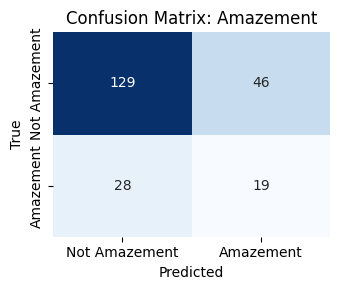

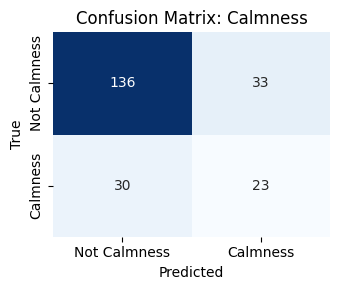

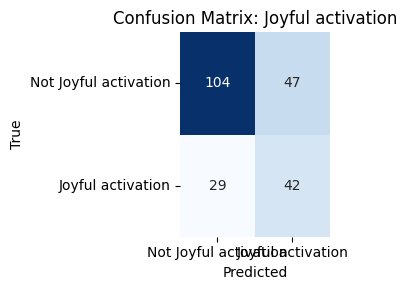

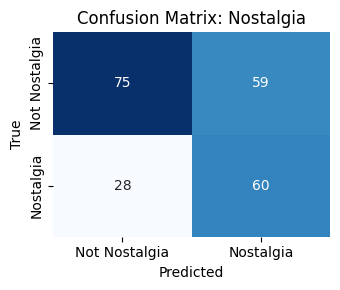

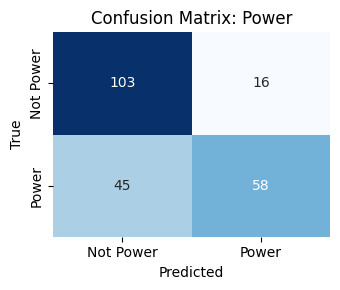

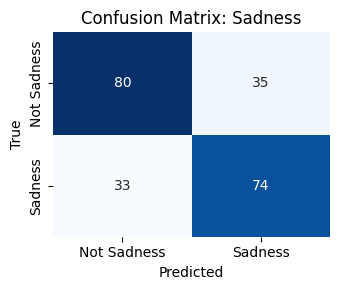

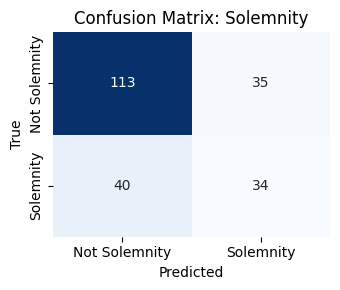

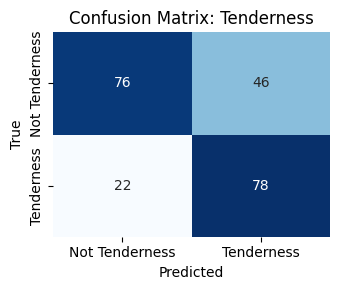

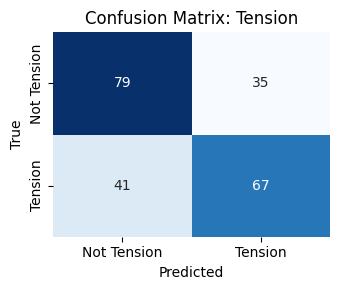

In [46]:
model_path = best_model_path

model, last_epoch, best_score = load_model_from_checkpoint(
    path=model_path,
    model_name=model_name,
    num_labels=len(all_emotions),
    device=device
)

model.eval()

train_f1_micro, train_f1_macro, train_prec, train_rec, train_acc, train_report, _, _ = evaluate(model, train_loader)
val_f1_micro, val_f1_macro, val_prec, val_rec, val_acc, val_report, val_labels, val_preds = evaluate(model, val_loader)

print("\nGENERAL PERFORMANCE AFTER TRAINING")
print("Train:")
print(f"F1 macro: {train_f1_macro:.4f}, F1 micro: {train_f1_micro:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, Acc: {train_acc:.4f}")
print(train_report)

print("\nValidation:")
print(f"F1 macro: {val_f1_macro:.4f}, F1 micro: {val_f1_micro:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, Acc: {val_acc:.4f}")
print(val_report)

plot_confusion_per_class(val_labels, val_preds, all_emotions)

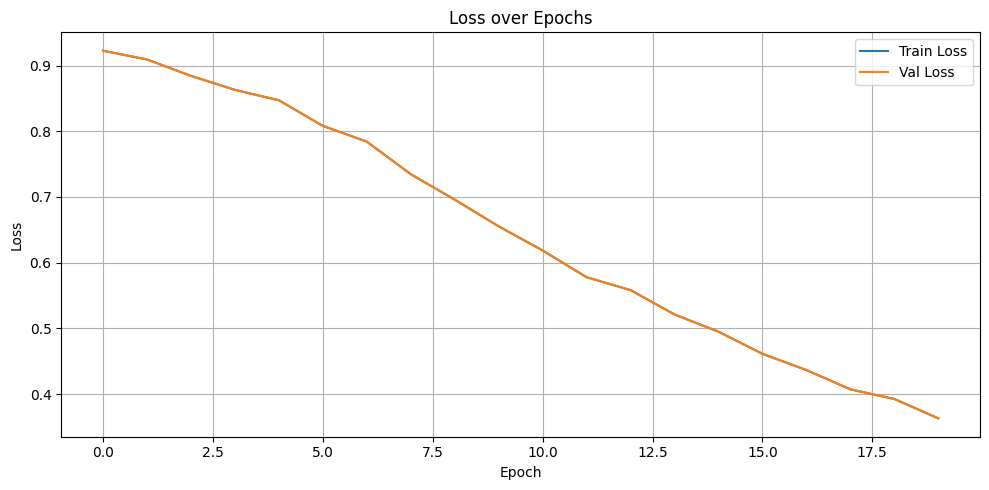

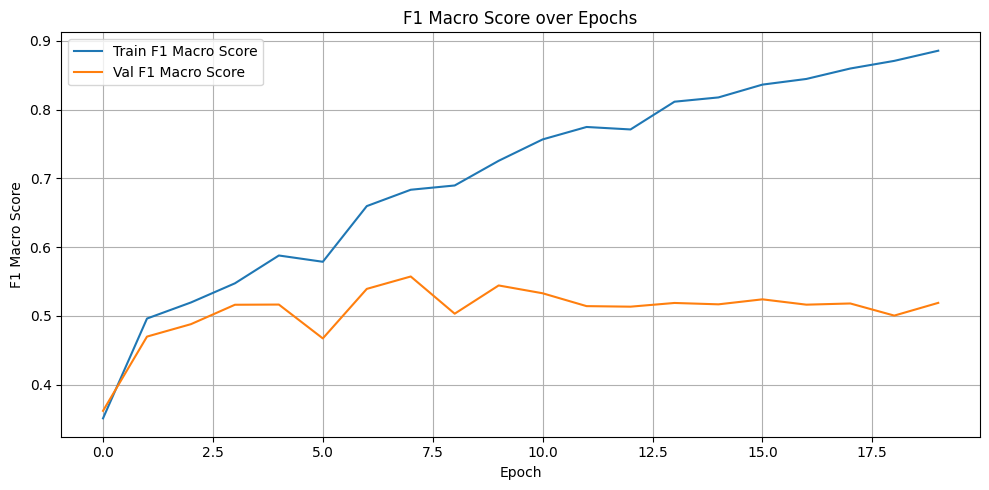

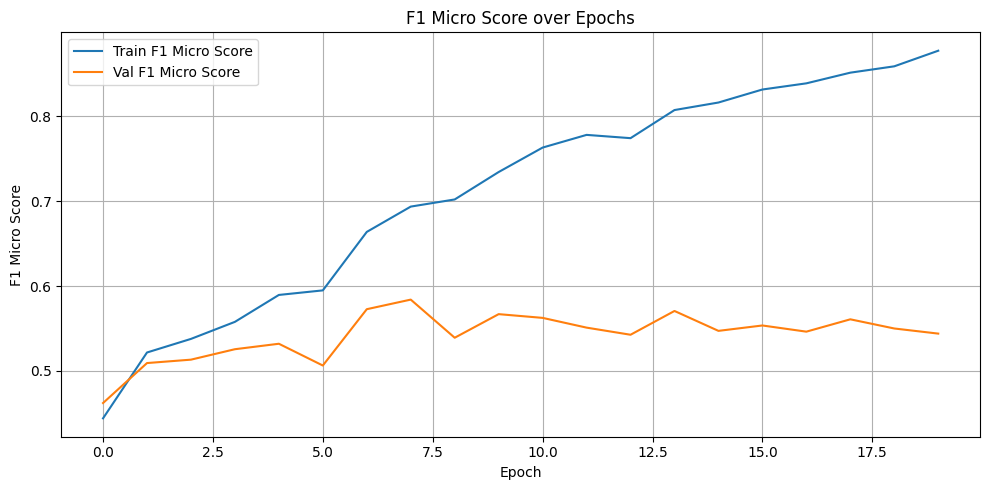

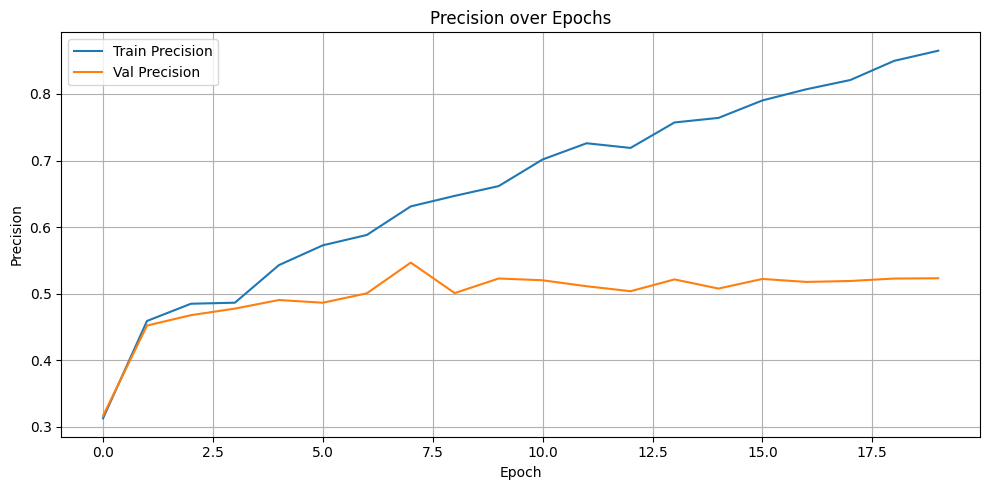

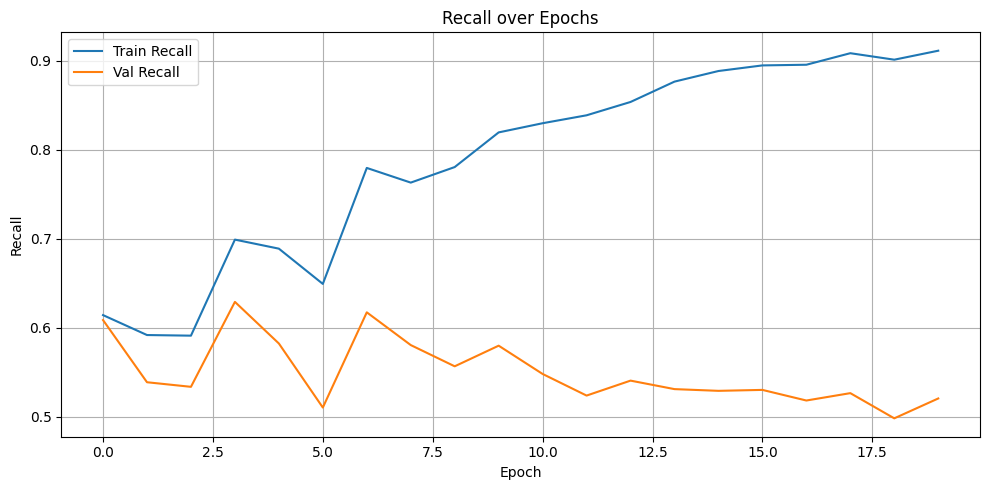

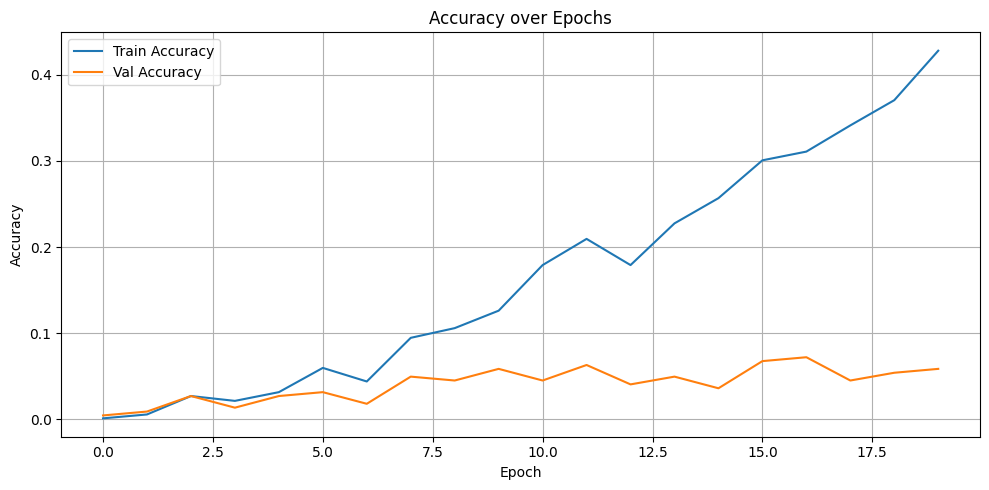

In [47]:
def plot_metrics(train, val, name):
    plt.figure(figsize=(10, 5))
    plt.plot(train, label=f'Train {name}')
    plt.plot(val, label=f'Val {name}')
    plt.xlabel("Epoch")
    plt.ylabel(name)
    plt.title(f"{name} over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{name.lower().replace(' ', '_')}_curve.png")
    plt.show()

plot_metrics(train_losses, train_losses, "Loss")
plot_metrics(train_f1macros, val_f1macros, "F1 Macro Score")
plot_metrics(train_f1micros, val_f1micros, "F1 Micro Score")
plot_metrics(train_precisions, val_precisions, "Precision")
plot_metrics(train_recalls, val_recalls, "Recall")
plot_metrics(train_accs, val_accs, "Accuracy")

In [48]:
def predict_emotions(text, model, tokenizer, threshold=0.5):
    model.eval()
    encoding = tokenizer(text,
                         max_length=512,
                         padding='max_length',
                         truncation=True,
                         return_tensors='pt')
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    preds = (probs >= threshold).astype(int)
    results = {emotion: float(prob) for emotion, prob in zip(all_emotions, probs)}
    predicted_emotions = [emotion for emotion, pred in zip(all_emotions, preds) if pred == 1]
    return predicted_emotions, results

In [49]:
text_ro = "O vreme, a fost greu în ultima vreme, am fost mai bine decât în ultimele patru decembrie reci pe care mi le amintesc. Și îmi văd familia în fiecare lună. Am găsit o fată pe care o iubesc părinții mei. Vine să stea peste noapte și cred că aș putea avea totul. Și îi mulțumesc lui Dumnezeu în fiecare zi pentru fata pe care mi-a trimis-o. Dar știu lucrurile pe care mi le dă, le poate lua. Și te țin în brațe în fiecare noapte. Și acesta e un sentiment cu care vreau să mă obișnuiesc. Dar nu există bărbat mai înspăimântat ca bărbatul care riscă să te piardă."
predicted_emotions_ro, probs_ro = predict_emotions(text_ro, model, tokenizer)
print("RO")
print("Predicted emotions:", predicted_emotions_ro)
print("Probabilities per emotion:", probs_ro)

text_en = "For a while, it's been hard lately, I've been better than I've been in the last four cold Decembers that I can remember. And I see my family every month. I found a girl that my parents love. She's coming to stay overnight and I think I could have it all. And I thank God every day for the girl he sent me. But I know the things he gives me, he can take away. And I hold you in my arms every night. And that's a feeling I want to get used to. But there's no man more scared than the man who risks losing you."
predicted_emotions_en, probs_en = predict_emotions(text_en, model, tokenizer)
print("EN")
print("Predicted emotions:", predicted_emotions_en)
print("Probabilities per emotion:", probs_en)

RO
Predicted emotions: ['Amazement', 'Joyful activation', 'Nostalgia', 'Solemnity', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.6382604241371155, 'Calmness': 0.38423952460289, 'Joyful activation': 0.5618950724601746, 'Nostalgia': 0.5074505805969238, 'Power': 0.3293304741382599, 'Sadness': 0.441786527633667, 'Solemnity': 0.584760844707489, 'Tenderness': 0.7494902610778809, 'Tension': 0.43590226769447327}
EN
Predicted emotions: ['Amazement', 'Joyful activation', 'Solemnity', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.6462787985801697, 'Calmness': 0.4055500030517578, 'Joyful activation': 0.577080249786377, 'Nostalgia': 0.4772642254829407, 'Power': 0.3557247221469879, 'Sadness': 0.4640713334083557, 'Solemnity': 0.5710147619247437, 'Tenderness': 0.713676393032074, 'Tension': 0.4235375225543976}


In [50]:
text_ro = "Simt cum îmi bate inima cu putere, e atât de greu să mă calmez, Sunt prea răbdător? Prea cald, m-a făcut să transpir pe podea (Ooh, transpir pe podea) Pur și simplu nu mai pot suporta (Woah-woah, oh, woah; Ah) Și suntem atât de aproape, văd în ochii tăi Dacă există o șansă o să profit, te implor, te rog dă-mi un semn Aștept de prea mult timp, cred că e timpul, mm-hmm Toată magia asta arde ca un foc înăuntru Și e mult prea cald, fată, ar trebui să ne eliberăm Am așteptat să fiu lângă tine Îmi dau seama cât de mult îți dorești și tu, ooh Toată tensiunea asta, iubito, eliberează-ți corpul (Ha) Suntem doar tu și eu Ne privim in ochi in aceasta cameră aglomerată Felul în care te uiți la mine, nu pot refuza Toată tensiunea asta, iubito, eliberează-ți corpul, da, iubito Coadă de cal așezată exact cum trebuie desfa-o fată, nu Fii timida, mă bucur că am spart gheața. Hai să continuăm să dansăm (Dansăm, dansăm). Iubito, ți-o pot da cum vrei (Cum vrei)."
predicted_emotions_ro, probs_ro = predict_emotions(text_ro, model, tokenizer)
print("RO")
print("Predicted emotions:", predicted_emotions_ro)
print("Probabilities per emotion:", probs_ro)

text_en = "I feel my heart pounding, it's so hard to calm down, Am I too patient? Too hot, got me sweating on the floor (Ooh, sweating on the floor) I just can't take it anymore (Woah-woah, oh, woah; Ah) And we're so close, I see it in your eyes If there's a chance I can take it, I'm begging you, please give me a sign I've been waiting too long, I think it's time, mm-hmm All this magic burns like a fire inside And it's way too hot, girl, we should let it loose I've been waiting to be get next to you I realize how much you want it too, ooh All this tension, baby, let your body loose (Ha) It's just you and me Locking eyes inside this crowded room The way you look at me, I can't refuse All this tension, baby, let your body loose, yeah, baby let it loose, ponytail sitting just right, Let it down, girl, don't be shy, I'm just glad we broke the ice. Let's on keep dancing (Dancing, dancing). Baby, I can give it to you any way you want (Any way you want)."
predicted_emotions_en, probs_en = predict_emotions(text_en, model, tokenizer)
print("EN")
print("Predicted emotions:", predicted_emotions_en)
print("Probabilities per emotion:", probs_en)

RO
Predicted emotions: ['Amazement', 'Joyful activation', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.5534806251525879, 'Calmness': 0.27035316824913025, 'Joyful activation': 0.5124291181564331, 'Nostalgia': 0.4947815239429474, 'Power': 0.34066155552864075, 'Sadness': 0.47009414434432983, 'Solemnity': 0.4663125276565552, 'Tenderness': 0.815263032913208, 'Tension': 0.4277372360229492}
EN
Predicted emotions: ['Joyful activation', 'Sadness', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.4874495565891266, 'Calmness': 0.30067265033721924, 'Joyful activation': 0.5199155807495117, 'Nostalgia': 0.4303087890148163, 'Power': 0.3857986330986023, 'Sadness': 0.5603461861610413, 'Solemnity': 0.47196319699287415, 'Tenderness': 0.7165303230285645, 'Tension': 0.4834032654762268}


In [51]:
text_ro = "Oamenii cred că sunt mare, dar sunt mic. Nu sunt mulțumit de obiective. Mă uit la visele mele, și tot cresc. Îmi dau un nume scării, do-re-mi-fa. Puterea Regelui Uriaș e o armă, urechile mele sunt deschise. O văd în ochii mei, e toxică, capacitatea mea e atât de mare. Sunt ca o furnică lucrătoare. Dar voi depăși durerea și voi deveni un gigant. Ne numesc Dumnezeul Zeilor. Să ne folosim puterile pe care le deținem pentru propriile lor dorințe, să le privim cum explodează. Sunt cunoscut ca un gigant. Nu, nu, nu, sunt, dar neg. Avem locuri de mers, avem locuri în care să curg. Nu sunt mulțumit, îmi doresc mai mult. Sunt un gigant (Suna-mă, sună-mă, sună-mă, sună-mă, sună-mă). Sunt un gigant, zdrobind lumi sub pământ. Sunt un gigant (Suna-mă, sună-mă, sună-mă, sună-mă, sună-mă). Sunt un gigant, trecând peste deficiențe. Aleargă, aleargă, aleargă înainte să venim, vino, vino. Ard, arde, arde, pentru că nu am terminat, gata, gata. Aleargă, aleargă, aleargă înainte să venim, vino, vino, sunt un gigant, zdrobind lumile de dedesubt"
predicted_emotions_ro, probs_ro = predict_emotions(text_ro, model, tokenizer)
print("Predicted emotions:", predicted_emotions_ro)
print("Probabilities per emotion:", probs_ro)

text_en = "People think I'm big, but I'm small. I'm not satisfied with goals. I look at my dreams, and I'm still growing. I give my ladder a name, do-re-mi-fa. The power of the Giant King is a weapon, my ears are open. I see it in my eyes, it's toxic, my capacity is so great. I'm like a worker ant. But I will overcome the pain and become a giant. I call ourselves the God of Gods. Let's use the powers we hold for our own desires, let's watch them explode. I'm known as a giant. No, no, no, I am, but I deny it. We have places to walk, we have places to flow. I'm not satisfied, I want more. I'm a giant (Call me, call me, call me, call me, call me). I'm a giant, crushing worlds underground. I'm a giant (Call me, call me, call me, Call me, call me. I'm a giant, overcoming shortcomings. Run, run, run before we come, come, come. Burn, burn, burn, because I'm not done, done, done. Run, run, run before we come, come, come, I'm a giant, crushing the worlds below."
predicted_emotions_en, probs_en = predict_emotions(text_en, model, tokenizer)
print("Predicted emotions:", predicted_emotions_en)
print("Probabilities per emotion:", probs_en)

Predicted emotions: ['Sadness', 'Solemnity', 'Tenderness', 'Tension']
Probabilities per emotion: {'Amazement': 0.48927420377731323, 'Calmness': 0.40975552797317505, 'Joyful activation': 0.4298468828201294, 'Nostalgia': 0.43245792388916016, 'Power': 0.4570283889770508, 'Sadness': 0.5165671706199646, 'Solemnity': 0.7698917388916016, 'Tenderness': 0.6126912832260132, 'Tension': 0.5486366748809814}
Predicted emotions: ['Amazement', 'Solemnity', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.5213578939437866, 'Calmness': 0.4484926462173462, 'Joyful activation': 0.43397408723831177, 'Nostalgia': 0.40944117307662964, 'Power': 0.4560938775539398, 'Sadness': 0.4727194011211395, 'Solemnity': 0.7977720499038696, 'Tenderness': 0.5476105809211731, 'Tension': 0.4963058531284332}
